## PROYECTO FINAL INTEGRADOR - ANÁLISIS Y RECOMENDACIÓN DE VINOS
---------------------

<img src="https://raw.githubusercontent.com/RodrigoVelasco19/Imagenes/main/Vino2.jpg" width="70%">

#### *Objetivo: Aplicar técnicas de exploración y transformación de datos (EDA y ETL), Machine Learning y Procesamiento de Lenguaje Natural (NLP) para extraer información valiosa sobre vinos y construir un sistema de recomendación basado en reseñas.*
---

### 0. Importación de librerias
---

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from textblob import Word
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

### 1. Descarga del dataset
---

In [8]:
from google.colab import files
files.upload()  # Esto permite subir el archivo kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rodrigovelasco19","key":"f606e4a149634ec863b5964f5cbb0e1c"}'}

In [9]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)
os.rename('kaggle.json', '/root/.kaggle/kaggle.json')

In [10]:
# Descargar el dataset de Kaggle
!kaggle datasets download -d zynicide/wine-reviews --unzip

Dataset URL: https://www.kaggle.com/datasets/zynicide/wine-reviews
License(s): CC-BY-NC-SA-4.0
 73% 37.0M/50.9M [00:00<00:00, 208MB/s] 
100% 50.9M/50.9M [00:00<00:00, 212MB/s]


In [11]:
#Se indaga el nombre de los archivos descargados
print(os.listdir("."))

['.config', 'winemag-data_first150k.csv', 'winemag-data-130k-v2.csv', 'winemag-data-130k-v2.json', 'sample_data']


In [12]:
# Se cargan los archivos CSV en 2 dataframes utilizando la librería Pandas
df1 = pd.read_csv("winemag-data-130k-v2.csv")
df2 = pd.read_csv("winemag-data_first150k.csv")

### 2. EDA y ETL
---

#### 2.1. Análisis preliminar de la data
----

In [13]:
# Se indaga el tamaño de los df
print("Tamaño de winemag-data-130k-v2.csv:")
print(df1.shape)

print("Tamaño de winemag-data_first150k.csv:")
print(df2.shape)

Tamaño de winemag-data-130k-v2.csv:
(129971, 14)
Tamaño de winemag-data_first150k.csv:
(150930, 11)


In [14]:
# Se visualizan las primeras filas de los df
df1.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [15]:
df2.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


Para continuar con el análisis en forma ordenada, se decide unir ambos archivos en un único dataframe y eliminar las columnas que no serán de utilidad para el análisis. De esta manera, se procede a eliminar las siguientes columnas:

- Unnamed: 0: es solo un índice.
- taster_name, taster_twitter_handle: no aportan a los objetivos del análisis.
- title: es redundante con winery y variety.
- designation: no aporta información relevante.

In [16]:
# Definir las columnas a conservar
columns_to_keep = ["country", "description", "points", "price",
                   "province", "region_1", "region_2", "variety", "winery"]

# Filtrar solo las columnas necesarias en ambos datasets
df1 = df1[columns_to_keep]
df2 = df2[columns_to_keep]

# Unir los datasets
df = pd.concat([df1, df2], ignore_index=True)

In [17]:
df.head()

,country,description,points,price,province,region_1,region_2,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,Etna,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,NaN,NaN,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Willamette Valley,Willamette Valley,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Lake Michigan Shore,NaN,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Sweet Cheeks


In [18]:
# Se indaga el tamaño del df resultante
print("Tamaño de dataset concatenado:")
print(df.shape)

Tamaño de dataset concatenado:
(280901, 9)


In [19]:
# Se analiza que tipo de datos incluye cada columna del del df
print("Tipos de datos del dataframe:")
df.info()

Tipos de datos del dataframe:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 280901 entries, 0 to 280900
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   country      280833 non-null  object 
 1   description  280901 non-null  object 
 2   points       280901 non-null  int64  
 3   price        258210 non-null  float64
 4   province     280833 non-null  object 
 5   region_1     234594 non-null  object 
 6   region_2     111464 non-null  object 
 7   variety      280900 non-null  object 
 8   winery       280901 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 19.3+ MB


In [20]:
# Se analiza cuantos valores nulos hay en cada columna del df:
print("Cantidad de valores nulos:")
df.isnull().sum()

Cantidad de valores nulos:


,0
country,68
description,0
points,0
price,22691
province,68
region_1,46307
region_2,169437
variety,1
winery,0


In [21]:
# Se analiza cuantas filas duplicadas hay en el df:
print("Cantidad de filas duplicadas en el df:")
print(df.duplicated().sum())

Cantidad de filas duplicadas en el df:
110381


#### CONCLUSIONES DEL ANÁLISIS PRELIMINAR:

- Se descargaron 2 datasets de Kaggle, cuya información es similar: cada fila representa un vino, y la información referida al mismo se distribuye en varias columnas: país de origen, reseña, puntaje, precio, etc.

- Se decide unir toda la información en un único dataframe concatenando la información original. A su vez, se decide eliminar las columnas que no aportan información relevante respecto a los objetivos definidos para el proyecto.

- El df resultante de la concatenación posee 280.901 filas cuyos datos se encuentran distribuidos en 9 columnas:

  1. country: País de origen del vino.

  2. description: Reseña escrita del vino. Puede incluir notas de sabor, aroma y recomendaciones.

  3. points: Puntuación del vino en una escala de 0 a 100, donde valores más altos indican mejor calidad.

  4. price: Precio del vino en dólares.

  5. province: Provincia o estado dentro del país donde se produce el vino.

  6. region_1: Primera subdivisión geográfica dentro de la provincia (puede ser una zona vinícola específica).

  7. region_2: Segunda subdivisión más específica dentro de la región_1 (puede estar vacía en algunos casos).

  8. variety: Tipo de uva con la que se produce el vino (ej. Cabernet Sauvignon, Merlot, Malbec).

  9. winery: Nombre de la bodega que produce el vino.

- Hay algunas columnas con valores nulos: region_2 (169.437), region_1	(46.307), price	(22691), country	(68), province	(68), variety	(1).

- El df posee un total de 110.381 filas duplicadas.

#### 2.2. Limpieza de los datos
----

Por la gran cantidad de valores nulos que poseen las columnas 'region_2' y 'region_1', y considerando que la localización de la zona donde se produjo el vino puede estar descripta por la información incluída en la columna ' province', se decide eliminar las 2 primeras del df.

In [22]:
# Se eliminan columnas 'region_1' y 'region_2' del df
df_clean = df.drop(columns=['region_1', 'region_2'])

Para evitar incluir en el df información repetida, se eliminan todas las filas duplicadas del mismo.

In [23]:
# Se eliminan filas duplicadas del df
df_clean = df_clean.drop_duplicates()

Por representar una pequeña cantidad de filas respecto al total, se eliminan las filas que poseen valores nulos en las columnas 'country', 'province' y 'variety'.

In [24]:
# Se eliminan filas con nulos en 'country', 'province' y 'variety'
df_clean = df_clean.dropna(subset=['country', 'province', 'variety'])

In [25]:
# Se analiza el tamaño del df luego de la limpieza
df_clean.shape

(169602, 7)

In [26]:
# Se analiza cuantos valores nulos hay en cada columna del df:
print("Cantidad de valores nulos:")
df_clean.isnull().sum()

Cantidad de valores nulos:


,0
country,0
description,0
points,0
price,12832
province,0
variety,0
winery,0


Se observa que luego de la limpieza, aún se tienen 12.832 valores nulos asociados al precio de los vinos. Una opción para conservar la información de los vinos sin precio, sería, tomar el promedio de los precios del vino anterior y el siguiente en la lista, considerando que tengan puntuaciones similares.

Se analizan las primeras 20 filas del df para ver si hay cierta correlación entre la puntuación y el precio de los vinos.

In [27]:
# Se analizan las primeras 20 filas
df_clean.head(20)

,country,description,points,price,province,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,Sicily & Sardinia,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",87,16.0,Sicily & Sardinia,Frappato,Terre di Giurfo
7,France,This dry and restrained wine offers spice in p...,87,24.0,Alsace,Gewürztraminer,Trimbach
8,Germany,Savory dried thyme notes accent sunnier flavor...,87,12.0,Rheinhessen,Gewürztraminer,Heinz Eifel
9,France,This has great depth of flavor with its fresh ...,87,27.0,Alsace,Pinot Gris,Jean-Baptiste Adam


Se observa a simple vista que no hay una correlación marcada entre el puntaje y el precio de los vinos, por lo tanto tomar el promedio del precio anterior y el posterior no necesariamente representaría un valor próximo a la realidad.

Se decide eliminar las filas con los vinos sin precio.

In [28]:
# Se eliminan filas con nulos en 'price'
df_clean = df_clean.dropna(subset=['price'])

In [29]:
# Se analiza cuantos valores nulos hay en cada columna del df:
print("Cantidad de valores nulos:")
df_clean.isnull().sum()

Cantidad de valores nulos:


,0
country,0
description,0
points,0
price,0
province,0
variety,0
winery,0


In [30]:
# Se analiza cuantas filas duplicadas hay en el df:
print("Cantidad de filas duplicadas en el df:")
print(df_clean.duplicated().sum())

Cantidad de filas duplicadas en el df:
0


In [31]:
# Se analiza el tamaño del df luego de la limpieza
df_clean.shape

(156770, 7)

Finalmente, luego de la limpieza, no tenemos valores nulos ni filas duplicadas en el dataframe. De las 280.901 filas que poseia originalmente el df, nos quedamos con 156.770 (56 % de la data original).

Para una mejor comprensión del df, se traducen los nombres de las columnas al español.

In [32]:
# Se crea diccionario con los nombres de las columnas traducidos al español
columnas_traducidas = {
    'country': 'pais',
    'description': 'descripcion',
    'points': 'puntuacion',
    'price': 'precio',
    'province': 'provincia',
    'variety': 'variedad',
    'winery': 'bodega'
}

# Se renombran las columnas del df
df_clean = df_clean.rename(columns=columnas_traducidas)
df_clean.head()

,pais,descripcion,puntuacion,precio,provincia,variedad,bodega
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Douro,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Oregon,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Michigan,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Oregon,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,87,15.0,Northern Spain,Tempranillo-Merlot,Tandem


In [33]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 156770 entries, 1 to 279610
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   pais         156770 non-null  object 
 1   descripcion  156770 non-null  object 
 2   puntuacion   156770 non-null  int64  
 3   precio       156770 non-null  float64
 4   provincia    156770 non-null  object 
 5   variedad     156770 non-null  object 
 6   bodega       156770 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 9.6+ MB


Ahora buscaremos outliers en función de la puntuación y del precio

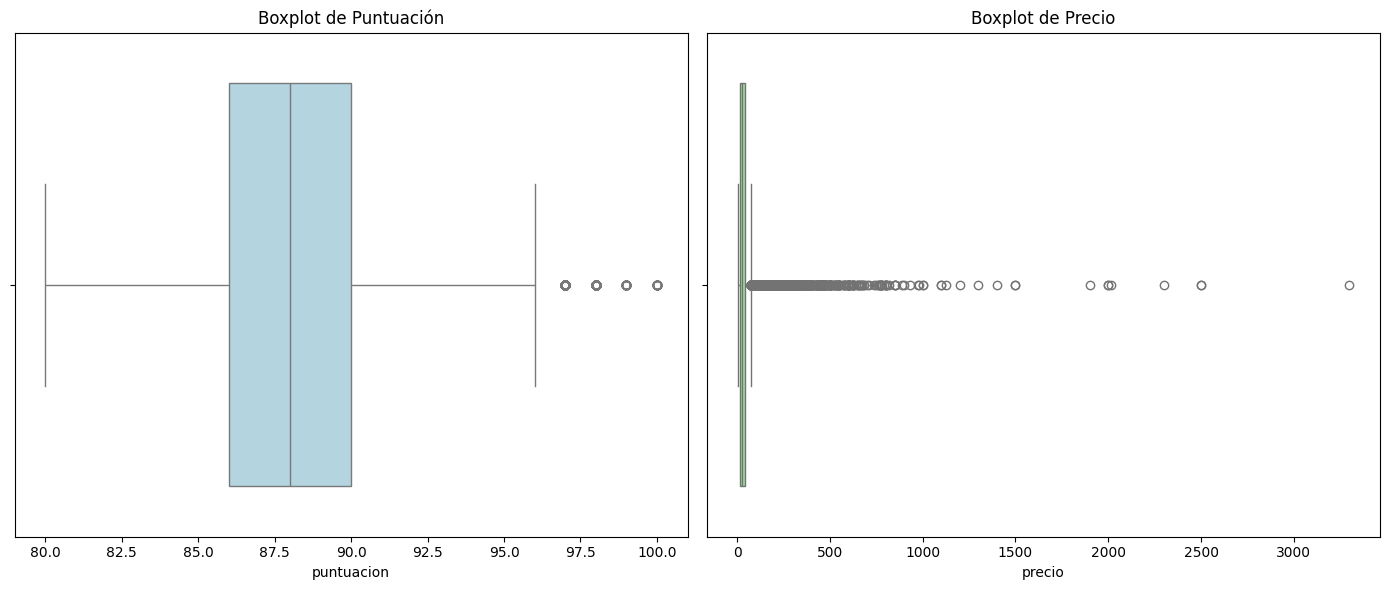

In [34]:
# Configurar el tamaño de la figura
plt.figure(figsize=(14, 6))

# Crear subgráficas para los boxplots
plt.subplot(1, 2, 1)  # (filas, columnas, índice)
sns.boxplot(x=df_clean['puntuacion'], color='lightblue')
plt.title('Boxplot de Puntuación')

plt.subplot(1, 2, 2)
sns.boxplot(x=df_clean['precio'], color='lightgreen')
plt.title('Boxplot de Precio')

# Mostrar las gráficas
plt.tight_layout()  # Asegura que las subgráficas no se superpongan
plt.show()

In [35]:
# Calcular los cuartiles
Q1 = df_clean['precio'].quantile(0.25)
Q3 = df_clean['precio'].quantile(0.75)

# Calcular el IQR
IQR = Q3 - Q1

# Calcular el límite superior del bigote
limite_superior = Q3 + 1.5 * IQR

# Mostrar el resultado
print(f"El límite superior del bigote para 'precio' es: {limite_superior:.2f}")

# Filtrar los vinos cuyo precio esté por encima del límite superior del bigote
outliers_precio = df_clean[df_clean['precio'] > limite_superior]

# Ver cuántos vinos están por encima del bigote superior
print(f"Número de vinos con precio superior al bigote superior: {outliers_precio.shape[0]}")

El límite superior del bigote para 'precio' es: 76.00
Número de vinos con precio superior al bigote superior: 9542


Se observa que el grafico tipo caja identifica algunos pocos valores como outliers en relación a la puntuación de los vinos. Sin embargo, estos se encuentran dentro de la escala (0-100) por lo tanto se decide conservarlos.

En relación al precio de los vinos, la gráfica identifica como outliers a todos aquellos vinos cuyo precio es superior a 76 dólares. Se observa que hay varios vinos definidos como outliers en la gráfica cuyo precio asciende hasta los 1000 uds aproximadamente. A su vez, hay unos pocos vinos con precios superiores a los 1000usd, que ascienden hasta los 4000 usd aproximadamente.

Debido a que posteriormente se buscará mediante modelos de Regresión Lineal y Random Forest efectuar una predicción sobre los precios de los vinos, y considerando que estos modelos son muy sensibles a valores extremos, se decide eliminar todas las filas con vinos cuyo precio sea superior a los 76 usd.

In [36]:
# Filtrar los vinos cuyo precio esté por debajo del límite superior del bigote
df_clean = df_clean[df_clean['precio'] <= limite_superior]

#### 2.3. Visualización de distribuciones
----

Se analiza la distribución de vinos en función de la puntuación (valores discretos).

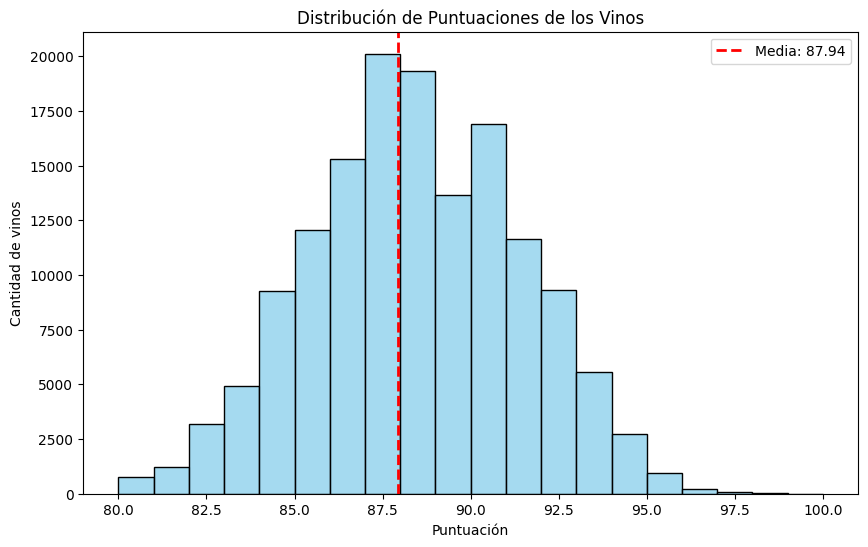

In [37]:
# Calcular la media de la puntuación
mean_points = df_clean['puntuacion'].mean()

# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Graficar la distribución de puntuaciones con histograma
sns.histplot(df_clean['puntuacion'], bins=20, color='skyblue', kde=False)

# Dibujar la línea de la media en rojo punteada
plt.axvline(mean_points, color='red', linestyle='dashed', linewidth=2, label=f'Media: {mean_points:.2f}')

# Etiquetas y título
plt.xlabel('Puntuación')
plt.ylabel('Cantidad de vinos')
plt.title('Distribución de Puntuaciones de los Vinos')

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

Se analiza la distribución de vinos en función del precio (valores continuos).

<ipython-input-38-f49f5337cc43>:8: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_clean['precio'], color='lightcoral', shade=True)


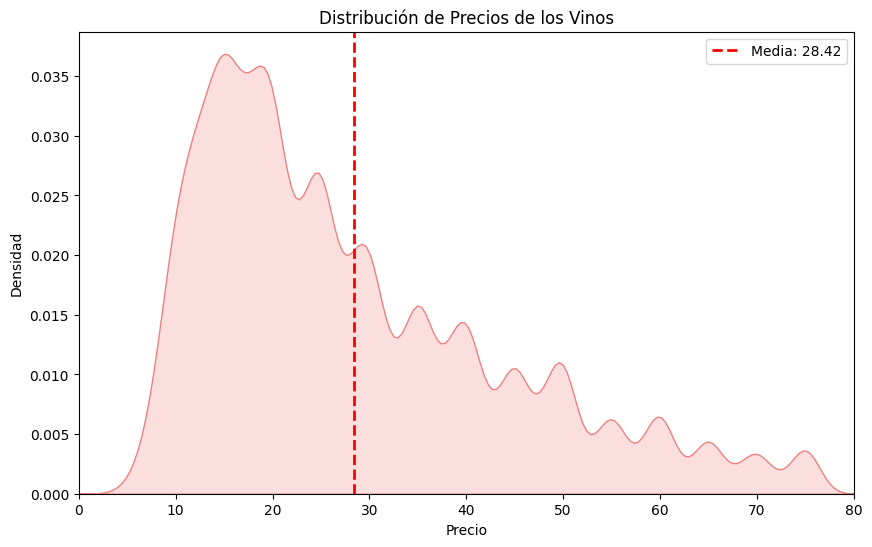

In [38]:
# Calcular la media del precio
mean_price = df_clean['precio'].mean()

# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Graficar la distribución del precio con solo KDE (curva de densidad)
sns.kdeplot(df_clean['precio'], color='lightcoral', shade=True)

# Dibujar la línea de la media en rojo punteada
plt.axvline(mean_price, color='red', linestyle='dashed', linewidth=2, label=f'Media: {mean_price:.2f}')

# Etiquetas y título
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.title('Distribución de Precios de los Vinos')

# Limitar el rango del eje x entre 0 y 80
plt.xlim(0, 80)

# Mostrar la leyenda
plt.legend()

# Mostrar la gráfica
plt.show()

Ahora analizamos la correlación que existe entre la puntuación y el precio de los vinos.

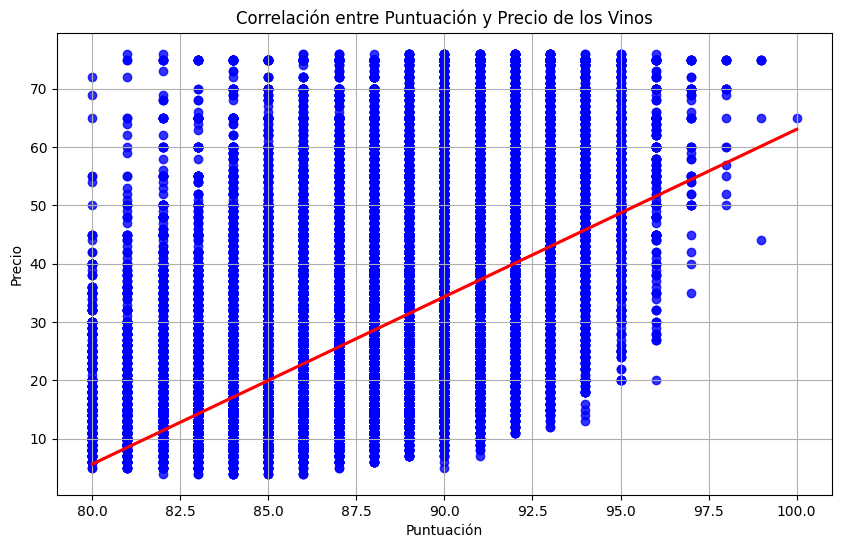

In [39]:
# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 6))

# Graficar el gráfico de dispersión con regresión lineal
sns.regplot(x='puntuacion', y='precio', data=df_clean, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'}, ci=None)

# Añadir grilla
plt.grid(True)

# Etiquetas y título
plt.xlabel('Puntuación')
plt.ylabel('Precio')
plt.title('Correlación entre Puntuación y Precio de los Vinos')

# Mostrar la gráfica
plt.show()

Analizamos la distribución de vinos por país, ordenándolos de mayos a menor cantidad de vinos.

<ipython-input-40-4d29bfd342dd>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_clean, x='pais', order=country_counts, palette='viridis')


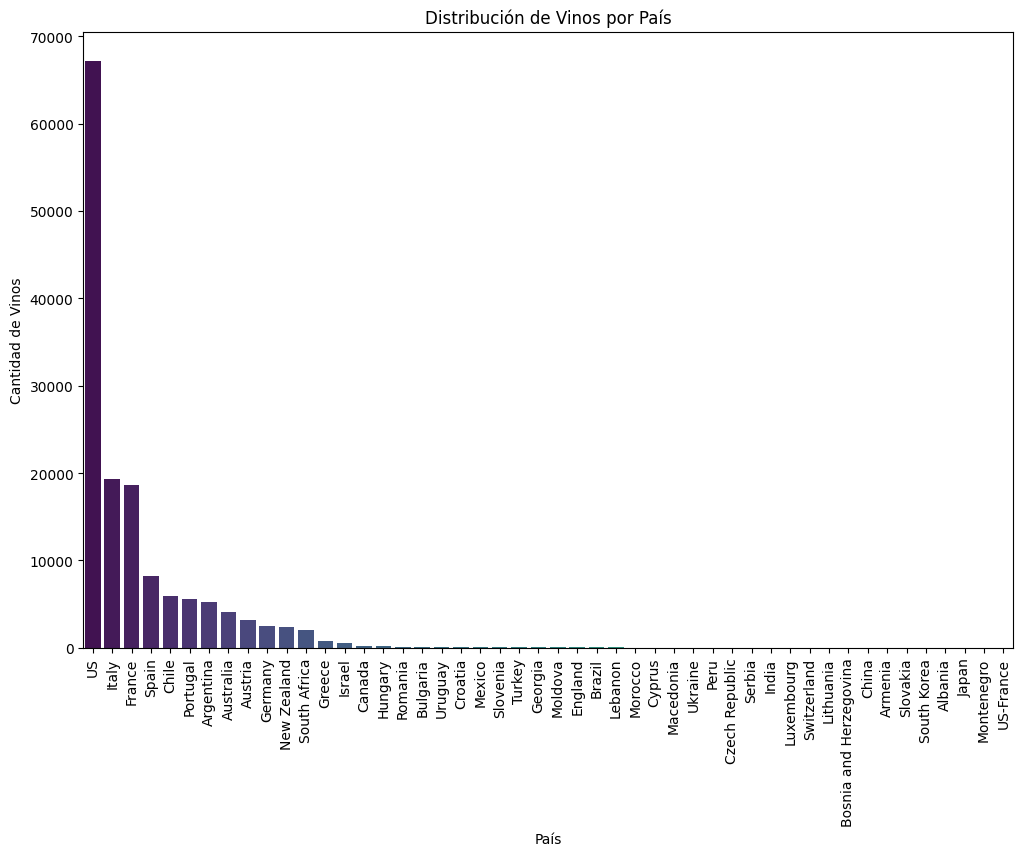

In [40]:
# Contar los vinos por país y ordenar de mayor a menor
country_counts = df_clean['pais'].value_counts().index

# Ajustar el tamaño del gráfico
plt.figure(figsize=(12, 8))

# Graficar la distribución de vinos por país ordenados de mayor a menor
sns.countplot(data=df_clean, x='pais', order=country_counts, palette='viridis')

# Etiquetas y título
plt.xlabel('País')
plt.ylabel('Cantidad de Vinos')
plt.title('Distribución de Vinos por País')

# Rotar las etiquetas del eje X para que se vean bien
plt.xticks(rotation=90)

# Mostrar la gráfica
plt.show()

Analizamos cómo se distribuyen los vinos en función de la variedad.

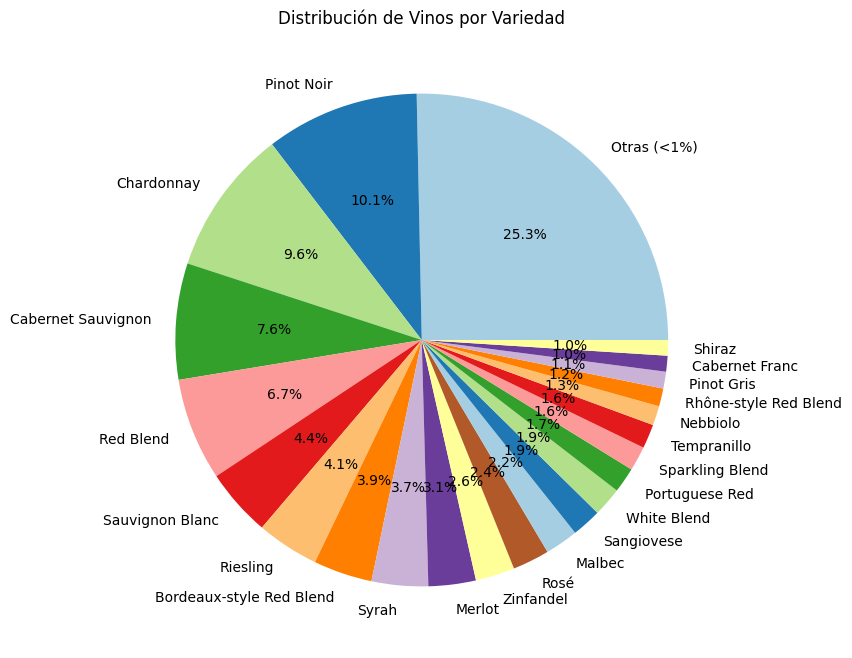

In [41]:

# Contar las variedades de vinos
variety_counts = df_clean['variedad'].value_counts()

# Calcular el porcentaje de cada variedad
variety_percentage = variety_counts / variety_counts.sum() * 100

# Agrupar las variedades con menos del 1% en "Otras (<1%)"
other_varieties = variety_percentage[variety_percentage < 1].index

# Crear una copia de la columna 'variedad' para modificar solo en la visualización
df_variety_temp = df_clean['variedad'].replace(other_varieties, 'Otras (<1%)')

# Contar las variedades después de la agrupación para la visualización
variety_counts_temp = df_variety_temp.value_counts()

# Ajustar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Graficar el gráfico de pastel con las nuevas categorías
plt.pie(variety_counts_temp, labels=variety_counts_temp.index, autopct='%1.1f%%', colors=plt.cm.Paired.colors)

# Título
plt.title('Distribución de Vinos por Variedad')

# Mostrar la gráfica
plt.show()